In [2]:
'''Objective:- Machine learning model (XGBoost) to predict house prices using features like:

Number of bedrooms (BedroomAbvGr)

Living area size (GrLivArea)

goal is:

"Given the house features, predict its price as accurately as possible."'''

'Objective:- Machine learning model (XGBoost) to predict house prices using features like:\n\nNumber of bedrooms (BedroomAbvGr)\n\nLiving area size (GrLivArea)\n\ngoal is:\n\n"Given the house features, predict its price as accurately as possible."'

Data Cleaning + XGBoost

In [3]:
!pip install xgboost
!pip install scikit-learn
!pip install psycopg2-binary
import pandas as pd
import psycopg2

In [4]:
# Connecting to PostgreSQL

conn = psycopg2.connect(
      dbname="real_estate",
      user = "postgres",
    password="123456789",
    host="localhost"
);

In [5]:
#Load the data

#data = pd.read_sql("SELECT BedroomAbvGr, GrLivArea, SalePrice, LotFrontage FROM house_prices",conn)


In [6]:
data =pd.read_csv("C:/Workspace/datasets/train (House Price) CLEAN.csv")

In [7]:
#Data Analyzing
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,GrLivArea,BedroomAbvGr,SalePrice
0,1,60,RL,65.0,8450,1710,3,208500
1,2,20,RL,80.0,9600,1262,3,181500
2,3,60,RL,68.0,11250,1786,3,223500
3,4,70,RL,60.0,9550,1717,3,140000
4,5,60,RL,84.0,14260,2198,4,250000


In [8]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,GrLivArea,BedroomAbvGr,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,1515.463699,2.866438,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,525.480383,0.815778,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,334.000000,0.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,1129.500000,2.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,1464.000000,3.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,1776.750000,3.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,5642.000000,8.000000,755000.000000


In [9]:
data.isnull().sum()

Id                0
MSSubClass        0
MSZoning          0
LotFrontage     259
LotArea           0
GrLivArea         0
BedroomAbvGr      0
SalePrice         0
dtype: int64

In [10]:
# Clean the Data

#Handle missing values
data['BedroomAbvGr'].fillna(data['BedroomAbvGr'].median(),inplace=True)

"""When to Use inplace=True?
✅ Use inplace=True when you want to modify the original DataFrame.
✅ Avoid it if you need a copy of the DataFrame before making changes."""

#Filter Realistic Homes
data = data[(data['BedroomAbvGr']>0) &(data['GrLivArea']<5000)]

data.columns

In [11]:
# OUTLIER Removal (Beyond Your Current Filters)
## Remove homes with extreme outliers (adjust thresholds as needed)
data = data[
    (data['BedroomAbvGr']>0) &
    (data['GrLivArea']<5000) &
    (data['SalePrice']<500000) # Filter ultra-high prices
]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1444 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1444 non-null   int64  
 1   MSSubClass    1444 non-null   int64  
 2   MSZoning      1444 non-null   object 
 3   LotFrontage   1187 non-null   float64
 4   LotArea       1444 non-null   int64  
 5   GrLivArea     1444 non-null   int64  
 6   BedroomAbvGr  1444 non-null   int64  
 7   SalePrice     1444 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 101.5+ KB


## Log Transform Skewed Features (Improves Model Performance)

In [13]:
import numpy as np

# Log-transform skewed features (common for prices/areas)
data['LogSalePrice'] = np.log1p(data['SalePrice'])
data['LogGrLivArea'] = np.log1p(data['GrLivArea'])
data['Logbedroomabvgr'] = np.log1p(data['BedroomAbvGr'])

# Convert back to actual prices [np.expm1(value) is reverse of log1p(value)].

In [14]:
data['LogSalePrice']

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: LogSalePrice, Length: 1444, dtype: float64

## Train XGBoost Model

##### XGBoost Model – Simplified Explanation
XGBoost (eXtreme Gradient Boosting) is a powerful, fast, and efficient machine learning algorithm mainly used for classification and regression problems. It improves gradient boosting by optimizing speed and performance.

##### How XGBoost Works (In Simple Terms)
It builds decision trees sequentially (one after another).

Each new tree fixes errors made by previous trees.

It gives higher weight to misclassified points.

Finally, it combines all trees to make a strong prediction model.

##### Key Hyperparameters (Tuning Tips)
n_estimators: Number of trees (higher = better accuracy, but slower).

learning_rate: Controls step size (0.1 is a good start).

max_depth: Limits tree depth (prevents overfitting).

subsample: Takes a fraction of data per tree (helps generalization).

##### Why Use XGBoost?
✔ Faster than other algorithms
✔ Handles missing values
✔ Works well for structured/tabular data
✔ Prevents overfitting with regularization

#### Key Points in Classification
Instead of XGBRegressor, we use XGBClassifier.

The target variable (y) must be binary (0 or 1) for classification.

Evaluation Metric (logloss): Measures classification error.

Hyperparameter tuning is similar to regression.

##### Why Use XGBoost for Classification?
✔ Handles large datasets efficiently
✔ Works well with missing values
✔ Prevents overfitting using regularization
✔ Fast and accurate compared to other classifiers

In [15]:
# Train XGBoost Model For_---Regression 
!pip install scikit-learn
!pip install xgboost


from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

x = data[['Logbedroomabvgr','LogGrLivArea']]
y = data['LogSalePrice']

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.2)

model = XGBRegressor()
model.fit(x_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
# Predict and Evalute
from sklearn.metrics import mean_squared_error

predictions = model.predict(x_test)

#Convert predicted log prices back to original prices
predicted_prices = np.expm1(predictions)

#Also if y_test is in log form
actual_prices = np.expm1(y_test)

rmse = (mean_squared_error(actual_prices,predicted_prices))**0.5

#RMSE (Root Mean Squared Error) tells you how far off your predictions are from the actual prices.

print(f"RMSE: ₹{rmse:,.2f}" )

RMSE: ₹48,132.48


C:\Users\badal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\badal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


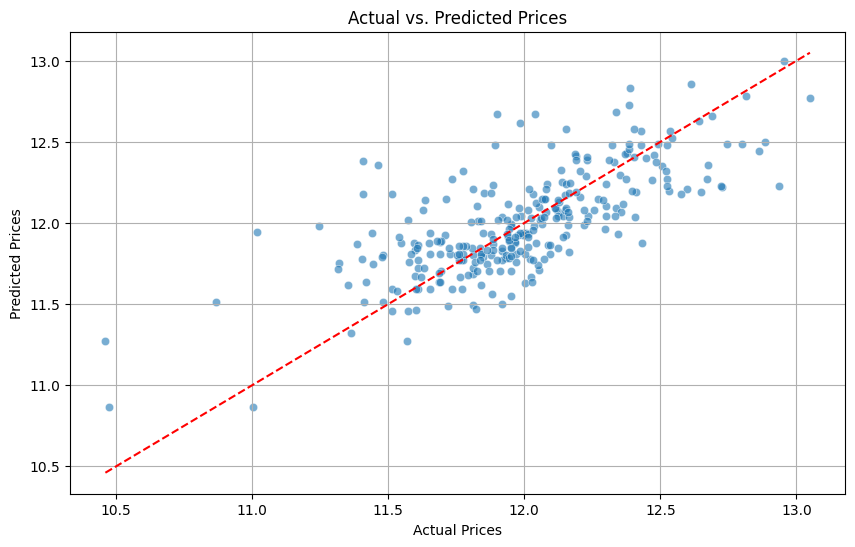

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Actual vs Predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True)
plt.show()



'''✅ What This Shows:
Each dot = one house

X-axis = real price

Y-axis = predicted price

Red dashed line = perfect prediction'''

## Improveing Model

In [18]:
#  a) Feature Engineering
#Adding more Column
data1 = pd.read_csv("C:/Workspace/datasets/train (House Price).csv")

In [19]:
print(data1.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [20]:
data = data1[["BedroomAbvGr", "GrLivArea", 'OverallQual', 'YearBuilt', 'SalePrice']]


In [21]:
data.columns

Index(['BedroomAbvGr', 'GrLivArea', 'OverallQual', 'YearBuilt', 'SalePrice'], dtype='object')

In [22]:
# Create New Features
data.loc[:,'Age'] = 2025 - data['YearBuilt'] #How ols is the house?
data.loc[:,'PricePerSqFt'] = data['SalePrice']/data['GrLivArea']

C:\Users\badal\AppData\Local\Temp\ipykernel_13812\245925260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'Age'] = 2025 - data['YearBuilt'] #How ols is the house?
C:\Users\badal\AppData\Local\Temp\ipykernel_13812\245925260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'PricePerSqFt'] = data['SalePrice']/data['GrLivArea']


In [23]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   BedroomAbvGr  1460 non-null   int64  
 1   GrLivArea     1460 non-null   int64  
 2   OverallQual   1460 non-null   int64  
 3   YearBuilt     1460 non-null   int64  
 4   SalePrice     1460 non-null   int64  
 5   Age           1460 non-null   int64  
 6   PricePerSqFt  1460 non-null   float64
dtypes: float64(1), int64(6)
memory usage: 80.0 KB


In [24]:
data.isnull().sum()

BedroomAbvGr    0
GrLivArea       0
OverallQual     0
YearBuilt       0
SalePrice       0
Age             0
PricePerSqFt    0
dtype: int64

In [25]:
# b. Hyperparameter Tuning
#Optimize XGBoost with GridSearchCV

'''Why use GridSearchCV?
Because machine learning models like XGBoost have hyperparameters 
(like tree depth, number of trees) that greatly affect performance.

You don’t know the best values in advance 
— so you try multiple combinations systematically and 
pick the best one using cross-validation.'''

from sklearn.model_selection import GridSearchCV  

param_grid = {  
    'n_estimators': [50, 100],  # Test 2 values (Try 50 and 100 trees)  
    'max_depth': [3, 6]  # Try tree depths of 3 and 6
}  
# Do 3-fold cross-validation for each combination
model = GridSearchCV(XGBRegressor(), param_grid, cv=3)  
model.fit(x_train, y_train)  
print(f"Best Params: {model.best_params_}")  

'''This will:

-Train 4 models (2x2 combos),

-Validate them using 3-fold CV,

-Pick the best one based on validation performance.

'''

Best Params: {'max_depth': 3, 'n_estimators': 50}


'This will:\n\n-Train 4 models (2x2 combos),\n\n-Validate them using 3-fold CV,\n\n-Pick the best one based on validation performance.\n\n'

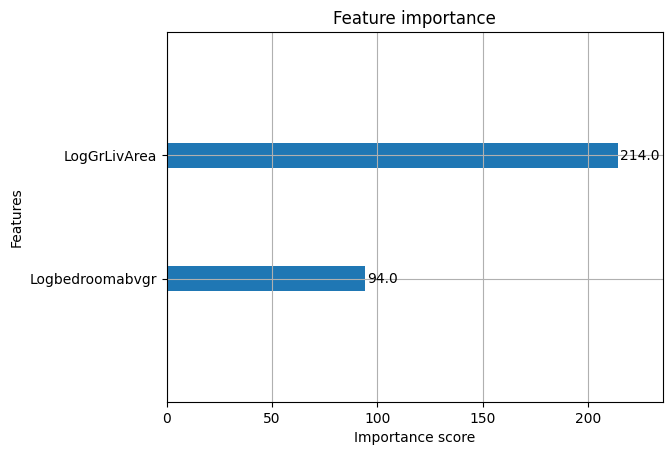

In [26]:
# c. Model Interpretation

from xgboost import plot_importance  
plot_importance(model.best_estimator_)  
plt.show()  

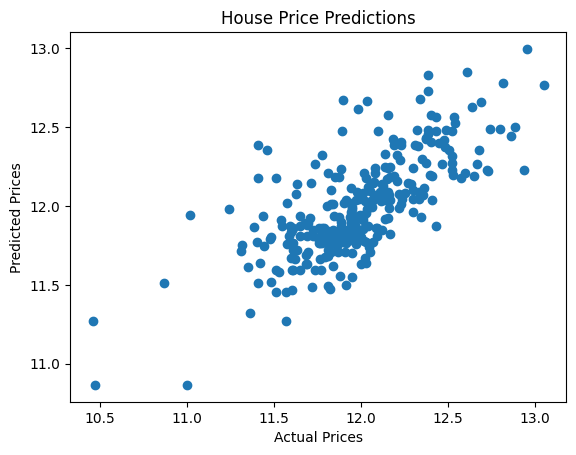

In [27]:
#2. Visualize Results 
#a. Actual vs. Predicted Plot

plt.scatter(y_test, predictions)  
plt.xlabel("Actual Prices")  
plt.ylabel("Predicted Prices")  
plt.title("House Price Predictions")  
plt.show()  

In [28]:
# b. Error Analysis
#Find the worst predictions (e.g., houses where the model was off by ₹10L+):
error = np.abs(predictions - y_test)
worst_predictions = x_test[error > 10_00_000] # Customize threshold 

In [29]:
worst_predictions = x_test[error > 5_00_000]  # Lower threshold  
print(worst_predictions.head())  

Empty DataFrame
Columns: [Logbedroomabvgr, LogGrLivArea]
Index: []
